# Tutorial SEGMOOMOE via web services

This notebook describes the usage of segomoe using web services exposed by WhatsOpt.

## Prerequisite

### wop (WhatsOpt command line interface)

You have to install the `wop` command:

```bash
pip install -U wop 
```

You need to be logged in a WhatsOpt server either by using the <code>wop</code> command in a shell or the WhatsOpt API as follows:

In [1]:
from whatsopt.whatsopt_client import WhatsOpt
wop = WhatsOpt(url="https://ether.onera.fr/whatsopt")
ok = wop.login(echo=True)

Successfully logged in to remote WhatsOpt https://selene.onecert.fr/whatsopt



To test if you are connected the following command should succeed

In [2]:
wop.check_versions()

WhatsOpt 1.30.0 requires wop >= 1.20.0
You are using wop 2.5.5


### SMT (Surrogate Modeling Toolbox)

SMT is not required per se, but is used in this notebook to get optimized LHS sampling method.

```bash
pip install smt
```

## Optimization with constraints

### Objective function

First we define the objective function we want to minimize

In [3]:
import numpy as np

def fun(x):  # function with 3 objectives
    x = np.atleast_2d(x)
    f1 = x[:, 0] - x[:, 1] * x[:, 2]
    f2 = 4 * x[:, 0] ** 2 - 4 * x[:, 0] ** x[:, 2] + 1 + x[:, 1]
    f3 = x[:, 0] ** 2
    return np.hstack((np.atleast_2d(f1).T, np.atleast_2d(f2).T, np.atleast_2d(f3).T))


def g1(x):  # constraint to force x < 0.8
    x = np.atleast_2d(x)
    return np.atleast_2d(x[:, 0] - 0.8).T


def g2(x):  # constraint to force x > 0.2
    x = np.atleast_2d(x)
    return np.atleast_2d(0.2 - x[:, 0]).T


def f_grouped(x):
    resfun = fun(x)
    resg1 = g1(x)
    resg2 = g2(x)
    res = np.hstack((resfun, resg1, resg2))
    return res

### Optimization

First we create an optimization context to use the SEGMOOMOE optimizer with the design space <code>xlimits</code>.

In [4]:
from whatsopt.mooptimization import MOOptimization, FLOAT, INT

xtypes = [{"type": FLOAT, "limits": [0., 1.]},
          {"type": INT, "limits": [0, 3]},
          {"type": INT, "limits": [0, 3]}]

cstr_specs = 2*[{"type": '<', "bound": 0.0}]

options={"n_clusters": 1, "criterion": "PI", "pop_size": 30, "n_gen": 30, "verbose": True, "debug": True}

optim = MOOptimization(xtypes, n_obj=3, cstr_specs=cstr_specs, options=options)

You can get the optimization identifier

In [5]:
optim._id

34

This id is be used to identify the optimization and visualize the results when using the WhatsOpt web application. It can also be used at a lower level to handle the optimization when using WhatsOpt REST API.

We need to have an initial DOE (n_samples, nx) and the corresponding outputs y (n_samples, 1).

In [6]:
import numpy as np
# from smt.sampling_methods import LHS
# lhs = LHS(xlimits=np.array(xlimits), criterion='ese')
# xdoe = lhs(5)

xdoe = np.array(
    [        
     [0.36691555, 0.,        1.        ],
     [0.58432706, 1.,       1.        ],
     [0.09227899, 1.,         2.        ],
     [0.95274182, 1.,         2.        ],
     [0.72873502, 1.,         3.        ],
     [0.87115983, 2.,         1.        ],
     [0.24346361, 2.,         3.        ],
     [0.4221473 , 2.,         0.        ],
     [0.10886813, 2.,         1.        ],
     [0.65557784, 3.,         2.        ],
     [0.39532629, 2.,         0.        ]
    ]
)
ydoe = f_grouped(xdoe)
print("Initial DOE")
print("xdoe={}".format(xdoe))
print("ydoe={}".format(ydoe))

Initial DOE
xdoe=[[0.36691555 0.         1.        ]
 [0.58432706 1.         1.        ]
 [0.09227899 1.         2.        ]
 [0.95274182 1.         2.        ]
 [0.72873502 1.         3.        ]
 [0.87115983 2.         1.        ]
 [0.24346361 2.         3.        ]
 [0.4221473  2.         0.        ]
 [0.10886813 2.         1.        ]
 [0.65557784 3.         2.        ]
 [0.39532629 2.         0.        ]]
ydoe=[[ 0.36691555  0.07084588  0.13462702 -0.43308445 -0.16691555]
 [-0.41567294  1.02844421  0.34143811 -0.21567294 -0.38432706]
 [-1.90772101  2.          0.00851541 -0.70772101  0.10772101]
 [-1.04725818  2.          0.90771698  0.15274182 -0.75274182]
 [-2.27126498  2.5762262   0.53105473 -0.07126498 -0.52873502]
 [-1.12884017  2.55103848  0.75891945  0.07115983 -0.67115983]
 [-5.75653639  3.17937335  0.05927453 -0.55653639 -0.04346361]
 [ 0.4221473  -0.28716663  0.17820834 -0.3778527  -0.2221473 ]
 [-1.89113187  2.61193656  0.01185227 -0.69113187  0.09113187]
 [-5.34442216 

We initialize the optimizer with the inital DOE.

In [7]:
optim.tell_doe(xdoe, ydoe)

We trigger the optimization using the "ask and tell" interface.

In [8]:
# We loop using the iteration budget
n_iter = 2
with_best=False
for i in range(n_iter):
    with_best = with_best or (i == n_iter - 1)
    x_suggested, status, x_opt, y_opt = optim.ask(with_best)
    print("{} x suggested = {} with status: {}".format(i, x_suggested, MOOptimization.STATUSES[status]))

    # compute objective function at the suggested point
    new_y = f_grouped(x_suggested)
    print("new y = {}".format(new_y))

    optim.tell(x_suggested, new_y)
         
print("Found approx pareto y_opt = {} at x_opt = {}".format(y_opt, x_opt))

0 x suggested = [0.7370702549962509, 3.0, 3.0] with status: pending
new y = [[-8.26292975  4.57137006  0.54327256 -0.06292975 -0.53707025]]
1 x suggested = [0.20000054130064435, 2.0, 2.0] with status: pending
new y = [[-3.79999946e+00  3.00000000e+00  4.00002165e-02 -5.99999459e-01
  -5.41300644e-07]]
Found approx pareto y_opt = [[0.027105600171699606, -0.9769517030888495, 0.312986916555557], [0.26890808642161046, -0.7147333354903309, -0.21207472228164226], [-2.435955088404744, 1.8686997180933123, -0.2146374673474123], [-8.20682127570078, 3.723265233215578, 0.9907868808012683], [-8.264820911134889, 4.540590761711645, 0.4270804028147521], [-5.761543606836482, 2.783497227716061, 0.1870968650452542], [-5.327682817300804, 4.3697497937100565, -0.214635882184961], [-8.152120695986888, 3.266006278243318, 0.41298855577838367], [-3.139971136335076, 2.4058868039800947, 0.5719412426536465], [-2.2907782534032703, 0.5463474142351912, 0.4128659417744393], [-1.5481165552769542, 0.019086939510204015, 

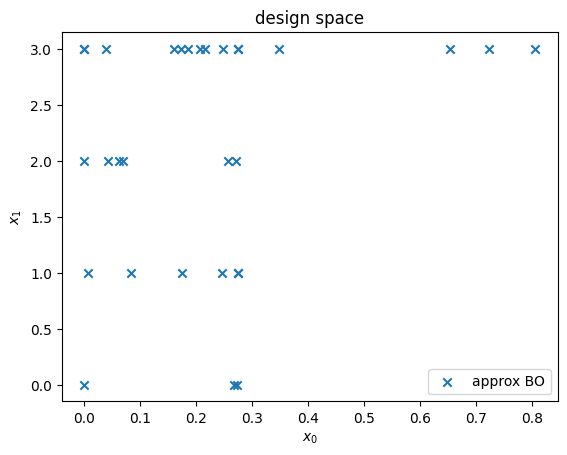

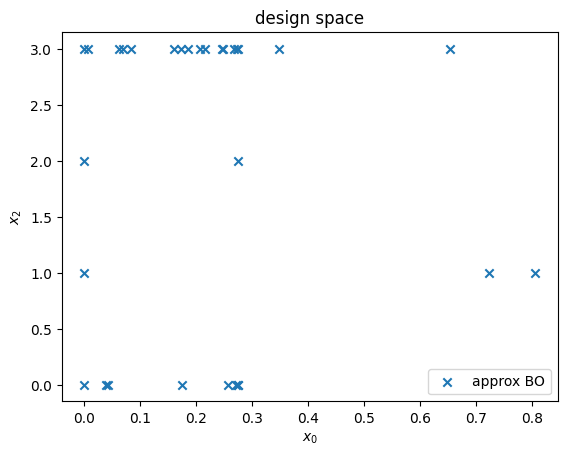

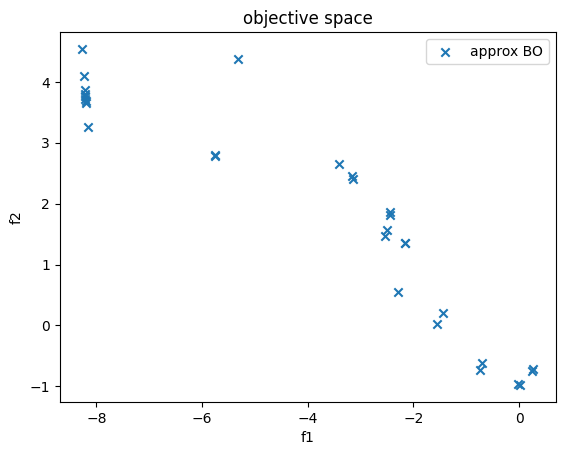

In [9]:
import matplotlib.pyplot as plt

x_opt = np.array(x_opt)
y_opt = np.array(y_opt)

plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,1], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.title("design space")
plt.show()


plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,2], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.legend()
plt.title("design space")
plt.show()

plt.figure()
plt.scatter( y_opt[:,0],  y_opt[:,1],marker='x', label = 'approx BO')
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend()
plt.title("objective space")
plt.show()

In [10]:
optim.tell_doe(xdoe, ydoe)

In [11]:
x_opt, y_opt = optim.run(f_grouped, n_iter=5)

0 x suggested = [0.621506214371434, 1.0, 3.0] with status: pending
new y = [[-2.37849379  2.58480314  0.38626997 -0.17849379 -0.42150621]]
1 x suggested = [0.7808470632950001, 3.0, 3.0] with status: pending
new y = [[-8.21915294  4.53448959  0.60972214 -0.01915294 -0.58084706]]
2 x suggested = [0.25375592195918173, 2.0, 0.0] with status: pending
new y = [[ 0.25375592 -0.74243173  0.06439207 -0.54624408 -0.05375592]]
3 x suggested = [0.4919306079221343, 1.0, 1.0] with status: pending
new y = [[-0.50806939  1.00026046  0.24199572 -0.30806939 -0.29193061]]
4 x suggested = [0.24656812958046048, 0.0, 0.0] with status: pending
x_best=[[0.20027477231028218, 2.0, 0.0], [2.220963272170362e-05, 0.0, 1.0], [0.20054804244293423, 3.0, 3.0], [0.38975362869629937, 0.0, 1.0], [0.19756238557465422, 3.0, 1.0], [0.20077780734771183, 2.0, 3.0], [0.7979380165269789, 1.0, 3.0], [0.20025455946310436, 2.0, 2.0], [0.199668805042126, 3.0, 2.0], [0.1876590775208521, 0.0, 1.0], [0.5259483857257506, 1.0, 2.0], [0.

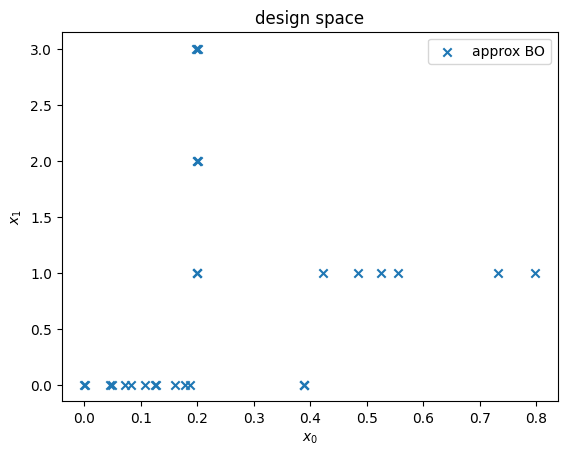

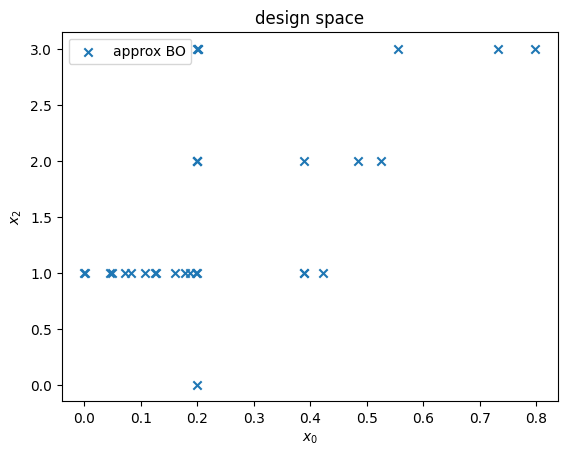

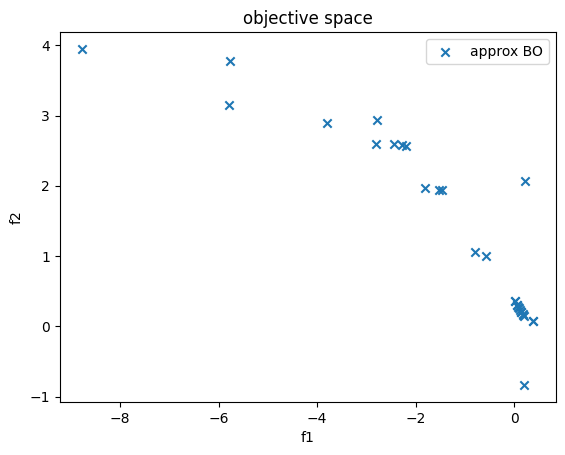

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,1], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.title("design space")
plt.show()


plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,2], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.legend()
plt.title("design space")
plt.show()

plt.figure()
plt.scatter( y_opt[:,0],  y_opt[:,1],marker='x', label = 'approx BO')
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend()
plt.title("objective space")
plt.show()

In [13]:
print(optim._id)

34


## Options

### Options for the optimization solver

In [14]:
# criterion="WB2S", "EHVI", "MPI", PI"
# If WB2S is chosen two other options: 'subcrit' has to be given
# subcrit= "EHVI", "MPI", "PI", by default: "EHVI" is set
# transfo=lambda x: np.sum(x): by default

# options={"n_clusters": 1, "n_start": 10, "criterion": "WB2S", "subcrit": "MPI" , "pop_size": 30, "n_gen": 30, "verbose": True, "debug": True}
options={"n_clusters": 1, "verbose": True, "debug": True}

optim_options = MOOptimization(xtypes, n_obj=3, cstr_specs=cstr_specs, options=options)
print(options)
optim_options.tell_doe(xdoe, ydoe)
x_opt, y_opt = optim_options.run(f_grouped, n_iter=5)


{'n_clusters': 1, 'verbose': True, 'debug': True}
0 x suggested = [0.621506214371434, 1.0, 3.0] with status: pending
new y = [[-2.37849379  2.58480314  0.38626997 -0.17849379 -0.42150621]]
1 x suggested = [0.3440809843650637, 1.0, 3.0] with status: pending
new y = [[-2.65591902  2.31062153  0.11839172 -0.45591902 -0.14408098]]
2 x suggested = [0.46660988832957523, 1.0, 1.0] with status: pending
new y = [[-0.53339011  1.0044596   0.21772479 -0.33339011 -0.26660989]]
3 x suggested = [0.3123393370680104, 0.0, 1.0] with status: pending
new y = [[ 0.31233934  0.1408661   0.09755586 -0.48766066 -0.11233934]]
4 x suggested = [0.280725219341119, 1.0, 3.0] with status: pending
x_best=[[0.25989553426173656, 2.0, 3.0], [0.3669907999008217, 1.0, 3.0], [0.3990470420335775, 2.0, 0.0], [0.4863439654609255, 3.0, 0.0], [0.17822117693336426, 2.0, 3.0], [0.20639588074284632, 2.0, 3.0], [0.333433868765621, 1.0, 0.0], [0.40208392822291983, 3.0, 0.0], [0.38320967956545626, 1.0, 2.0], [0.37148280692971486, 2

In [15]:
print(optim_options._id)

35


### Optimization with mixed variables: float, integer and categorical variables

In [16]:
from smt.applications.mixed_integer import MixedIntegerSamplingMethod
from smt.sampling_methods import LHS
import numpy as np
from whatsopt.mooptimization import MOOptimization, FLOAT, INT, ENUM
import time
from smt.utils.design_space import (
    CategoricalVariable,
    DesignSpace,
    FloatVariable,
    IntegerVariable,
)


$$
\begin{array}{cl}
    \underset{x\in \mathbb{R}^3}{\min} (f_1(x),f_2(x),f_3(x)) & \\
    \mbox{with} & f_1=x_0-x_1x_2 \\
    & f_2= 4x_0^2 - 4x_0^{x_2} +1 + x_1\\
    & f_3= x_0^2\\
    \mbox{s.t.} & g_1(x)=x_0-0.8 \ge 0  \\
    &  g_2(x) = 0.2-x_0 \ge 0
\end{array}
$$

Here 
- $x_0\in [0,1] \subset \mathbb{R}$
- $x_1$ is a integer $\in \{0,1,2,3\}$  4 possibilities
- $x_2$ is a categorical variable $\in \{"blue","red","green"\}$ : 3 levels

In [17]:
def fun_mixed_color(x):#function with 3 objectives
    if x[2]=="blue":
        x2=0
    elif x[2]=="red":
        x2=1
    elif x[2]=="green":
        x2=2
    f1 = x[0] -float(x[1])*x2
    f2 = 4*x[0]**2 - 4*x[0]**x2 +1 + float(x[1])
    f3= x[0]**2
    return [f1,f2,f3]

def g1(x):#constraint to force x < 0.8
    return (x[0]-0.8, False)
def g2(x):#constraint to force x > 0.2
    return (0.2 - x[0], False)

# To group functions relative to objective &  constraint 
def f_grouped(x):
    #print('ds fgrouped',x)
    resfun = fun_mixed_color(x)
    resg1 = g1(x)[0]
    resg2 = g2(x)[0]
    #print(resfun, resg1,resg2)
    res = np.hstack((resfun, resg1, resg2))
    return res,False

# Specifications for constraints 
cstr_specs = 2*[{"type": '<', "bound": 0.0}]

# Definition of design variables 
xtypes_whatsopt = [{"type": FLOAT, "limits": [0.0, 1.0]},
                   {"type": INT,  "limits": [0, 3]},
                   {"type": ENUM,  "limits": ["blue","red","green"]}]

design_space = DesignSpace(
            [
                FloatVariable(0.0, 1.0),
                IntegerVariable(0, 3),
                CategoricalVariable(["blue", "red", "green"]),
            ]
        )

In [18]:
options={"n_clusters": 1, "criterion": "MPI", "pop_size": 30, "n_gen": 30, "verbose": True, "debug": True}
# options["mod_obj__type"]       ="MIXED"
# options["mod_obj__name"]       ="KPLS"
# options["mod_obj__n_comp"]     = 2 # PLS components to reduce the initial dimension
# options["mod_obj__eval_noise"] = False
# options["mod_obj__corr"]       = "squar_exp" # correlation kernel

In [19]:
optim = MOOptimization(xtypes_whatsopt, cstr_specs=cstr_specs, n_obj=3,  options=options)

In [20]:
sampling = MixedIntegerSamplingMethod(LHS, design_space=design_space, criterion="ese")

num = 20
xdoe = sampling(num)
print("Initial DOE")
print("xdoe={}".format(xdoe))

Initial DOE
xdoe=[[ 0.37454012  2.          0.        ]
 [ 0.95071431 -0.          1.        ]
 [ 0.73199394  1.          0.        ]
 [ 0.59865848  1.          2.        ]
 [ 0.15601864  1.          0.        ]
 [ 0.15599452  3.          1.        ]
 [ 0.05808361 -0.          0.        ]
 [ 0.86617615  2.          1.        ]
 [ 0.60111501  2.          1.        ]
 [ 0.70807258 -0.          0.        ]
 [ 0.02058449  2.          2.        ]
 [ 0.96990985 -0.          2.        ]
 [ 0.83244264 -0.          2.        ]
 [ 0.21233911  3.          2.        ]
 [ 0.18182497  3.          1.        ]
 [ 0.18340451  3.          2.        ]
 [ 0.30424224  1.          0.        ]
 [ 0.52475643 -0.          0.        ]
 [ 0.43194502  2.          0.        ]
 [ 0.29122914  1.          0.        ]]


In [21]:
# To have the DOE with the original values (float, integer and categorical)

xdoe_cat=design_space.correct_get_acting(xdoe)[0]
print(xdoe_cat)
print()
ydoe= np.array([f_grouped(design_space.decode_values(xdoe_cat[i]))[0] for i in range(len(xdoe))])
print('DOE with original  values - first elements - objectives \n', design_space.decode_values(xdoe_cat[:5]),'\n', ydoe[:5])
print('DOE to give to the WhatsOpt optimizer - first elements - obj & constraints \n', xdoe[:5],'\n', ydoe[:5])


[[0.37454012 2.         0.        ]
 [0.95071431 0.         1.        ]
 [0.73199394 1.         0.        ]
 [0.59865848 1.         2.        ]
 [0.15601864 1.         0.        ]
 [0.15599452 3.         1.        ]
 [0.05808361 0.         0.        ]
 [0.86617615 2.         1.        ]
 [0.60111501 2.         1.        ]
 [0.70807258 0.         0.        ]
 [0.02058449 2.         2.        ]
 [0.96990985 0.         2.        ]
 [0.83244264 0.         2.        ]
 [0.21233911 3.         2.        ]
 [0.18182497 3.         1.        ]
 [0.18340451 3.         2.        ]
 [0.30424224 1.         0.        ]
 [0.52475643 0.         0.        ]
 [0.43194502 2.         0.        ]
 [0.29122914 1.         0.        ]]

DOE with original  values - first elements - objectives 
 [[0.3745401188473625, 2.0, 'blue'], [0.9507143064099162, 0.0, 'red'], [0.7319939418114051, 1.0, 'blue'], [0.5986584841970366, 1.0, 'green'], [0.15601864044243652, 1.0, 'blue']] 
 [[ 0.37454012 -0.4388788   0.1402803  -0.

In [22]:
optim.tell_doe(xdoe, ydoe)

In [23]:
# We loop using the iteration budget
n_iter = 10
with_best=False
for i in range(n_iter):
    with_best = with_best or (i == n_iter - 1)
    start_time = time.time()
    x_suggested, status, x_opt, y_opt = optim.ask(with_best)
    print("{} x suggested = {} with status: {}".format(i, x_suggested, MOOptimization.STATUSES[status]))
    print("--- %s seconds ---" % (time.time() - start_time))
    # compute objective functions & constraints  at the suggested point
    new_y = f_grouped(design_space.decode_values(np.array(x_suggested)))[0]
    print("new y = {}".format(new_y))
    
    optim.tell(x_suggested, new_y)
         
print("Found approx pareto y_opt = {} at x_opt = {}".format(y_opt, x_opt))

0 x suggested = [0.20000107614401472, 2.0, 1.0] with status: pending
--- 19.20342516899109 seconds ---
new y = [-1.79999892e+00  2.35999742e+00  4.00004305e-02 -5.99998924e-01
 -1.07614401e-06]
1 x suggested = [0.5036664306421086, 1.0, 1.0] with status: pending
--- 20.30583381652832 seconds ---
new y = [-0.49633357  1.00005377  0.25367987 -0.29633357 -0.30366643]
2 x suggested = [0.20000307247630156, 1.0, 2.0] with status: pending
--- 20.318299531936646 seconds ---
new y = [-1.79999693e+00  2.00000000e+00  4.00012290e-02 -5.99996928e-01
 -3.07247630e-06]
3 x suggested = [0.20000077972656544, 1.0, 1.0] with status: pending
--- 20.553574562072754 seconds ---
new y = [-7.99999220e-01  1.35999813e+00  4.00003119e-02 -5.99999220e-01
 -7.79726565e-07]
4 x suggested = [0.20059743999866006, 1.0, 1.0] with status: pending
--- 25.09089684486389 seconds ---
new y = [-7.99402560e-01  1.35856757e+00  4.02393329e-02 -5.99402560e-01
 -5.97439999e-04]
5 x suggested = [0.20110865817082463, 1.0, 1.0] wi

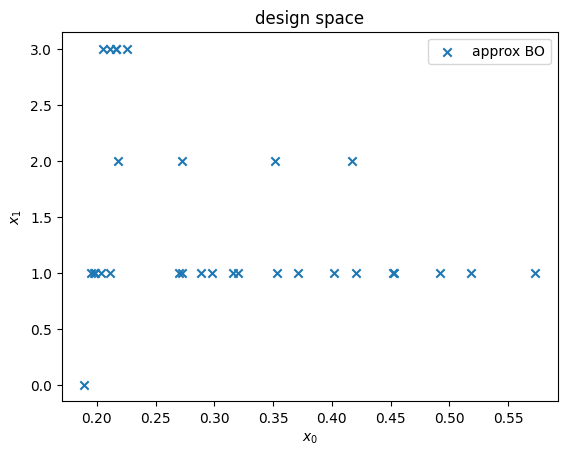

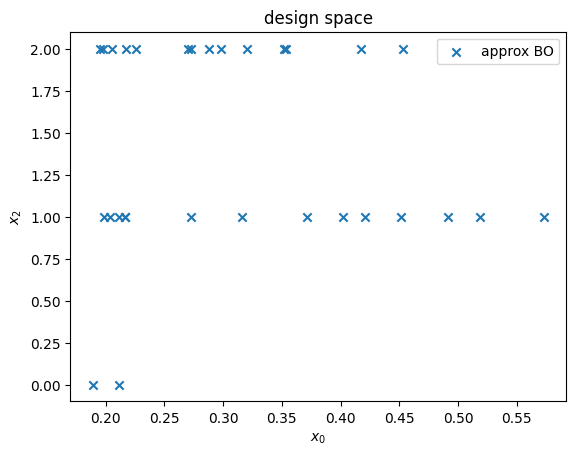

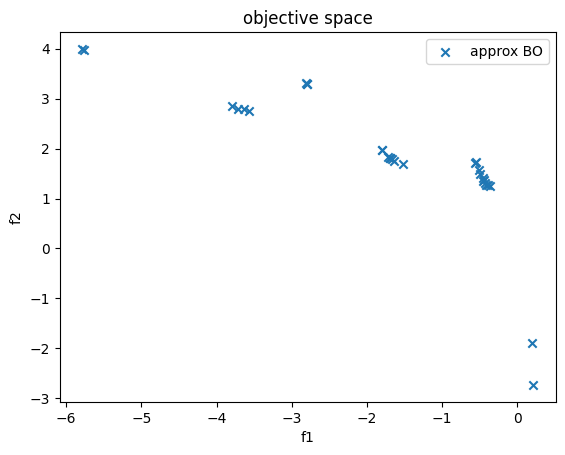

In [24]:
import matplotlib.pyplot as plt

x_opt = np.array(x_opt)
y_opt = np.array(y_opt)

plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,1], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.title("design space")
plt.show()

plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,2], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.legend()
plt.title("design space")
plt.show()

plt.figure()
plt.scatter( y_opt[:,0],  y_opt[:,1],marker='x', label = 'approx BO')
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend()
plt.title("objective space")
plt.show()